<img src="../../code/Resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Population Coding Exercises</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

In [1]:
import multiprocessing as mp
import os
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (KFold, LeaveOneOut, RepeatedKFold,
                                     RepeatedStratifiedKFold, StratifiedKFold)
from tqdm import tqdm

mp.set_start_method('fork')

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "./"
data_dir = os.path.join(base_dir, "data")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [3]:
def make_response_array(spike_times, stimulus_presentations, units, window=.05):

    '''
    Create an array of spike counts x stimulus presentations, and a corresponding list of stimulus labels.
    spike_times: spike times 
    stimulus_presentation: stimulus presentation table
    units: units table containing only the units to get the responses of
    '''

    # Sort spike times chronologically; necessary for the binary search later
    sorted_spikes = dict()
    for iu in units.index:
        # Use mergesort/timsort since most spike_times are already sorted
        sorted_spikes[iu] = np.sort(spike_times[iu], kind='mergesort')

    # Create our own copy of stimulus presentations and sort by presentation start time chronologically
    # Sorting of stimulus_presentations isn't necessary, but it speeds up the vectorized `searchsorted(...)`
    stimulus_presentations = stimulus_presentations.sort_values(by='start_time', kind='mergesort', inplace=False)

    # Calculate the duration of stimulus presentations, and drop NaN durations
    stimulus_presentations['duration'] = stimulus_presentations['end_time'] - stimulus_presentations['start_time']
    stimulus_presentations.dropna(subset='duration', inplace=True)
    
    # Warn if window size is too big
    if np.any(window > stimulus_presentations['duration']):
        print('Warning: window size longer than stimulus presentation')

    responses_by_unit = list()
    for iu in units.index:
        unit_spike_times = sorted_spikes[iu]

        # Determine the first and last spike time for each stimulus presentation
        start_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time'])
        end_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time'] + window)

        # Calculate the response rate for each stimulus presentation
        responses_by_unit.append((end_is - start_is) / stimulus_presentations['duration'])

    # responses_by_unit has each row as a unit, and each column as a stimulus, flip so that rows are stimuli
    responses = np.transpose(responses_by_unit)

    # Extract the labels that match the responses from our sorted stimulus presentations table
    labels = np.array(stimulus_presentations['image_name'])
    
    return responses, labels

<div class="alert alert-block alert-success">

<h2>Exercise 2.1: Decoding for Different Brain Areas, Behavioral States, and Stimuli</h2>

<p>
In the afternoon session we looked at decoding performance, restriciting the analysis to 
<ol>
<li>one brain area ('VISp'),</li>
<li>one stimulus set ('Natural_Images_Lum_Matched_set_ophys_G_2019'), and</li>
<li>only one type of trials ('active')</li>
</ol>
It's time to generalize! Let's plot the decoding performance for each brain area recorded seperated by running/not running trials. Consider further all stimulus sets with moderate amount (10-500) of stimulus conditions.

<p>
<strong>Note:</strong>  For this exercise, there are comments with detailed prompts that act as guiderails. But feel free to try completing the task objectives using your own approach first, and consulting our prompts if you get stuck.
</p>
    
</div>

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.a:</strong> As we did in the lecture, retrieve data of session 1065437523 from the  <code>VisualBehaviorNeuropixelsProjectCache</code>.

</div>

In [4]:
cacheVB = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=Path(data_dir))

sessionVB = cacheVB.get_ecephys_session(ecephys_session_id=1065437523)

/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.1.b:</strong> Obtain the <strong>annotated</strong> stimulus presentations for the session using the <code>behavior_utils</code> package.

</div>

In [5]:
annotated_stim_table = behavior_utils.get_annotated_stimulus_presentations(sessionVB)
annotated_stim_table.columns

name 'change_time' is not defined


Index(['stimulus_block', 'image_name', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'flashes_since_change', 'trials_id', 'position_x', 'stimulus_name',
       'spatial_frequency', 'is_sham_change', 'color', 'position_y',
       'stimulus_index', 'temporal_frequency', 'active', 'orientation',
       'rewarded', 'contrast', 'licks', 'mean_running_speed',
       'mean_pupil_width', 'reward_rate', 'engaged', 'engagement_state',
       'epoch'],
      dtype='object')

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.c:</strong> Plot histograms of <code>mean_pupil_width</code> and <code>mean_running_speed</code>.

</div>

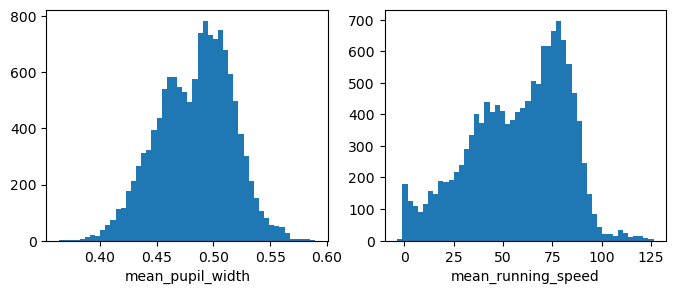

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
for i, key in enumerate(("mean_pupil_width", "mean_running_speed")):
    ax[i].hist(annotated_stim_table[key],50)
    ax[i].set_xlabel(key);

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.d:</strong> As we just observed, in the VB dataset, the mice were nearly always running. To consider a dataset that includes trials where mice are 'not running', let's turn to the VC dataset. Retrieve data of session 798911424 from the <code>EcephysProjectCache</code>.

</div>

In [7]:
cache = EcephysProjectCache.from_warehouse()

session = cache.get_session_data(798911424)

/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.1.e:</strong> Retrieve unit data, sort the units by depth, and filter for 'good' units using the same criteria as in the lecture.

</div>
<details>
    <summary>Click for <strong>Hints:</strong></summary>
    Unlike for VB (Prompt 2.1.b), here the session object has no <code>get_units</code> method, but a <code>units</code> attribute that already contains channel information, thus no merging is necessary.
</details>

In [8]:
units = session.units # contains information about spike waveforms, isolation quality
units = units.sort_values('probe_vertical_position', ascending=False)
#now we'll filter them
good_unit_filter = ((units['snr']>1)&
                    (units['isi_violations']<1)&
                    (units['firing_rate']>0.1))
good_units = units.loc[good_unit_filter]

/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div class="alert alert-block alert-success">

<strong>Prompt 2.1.f:</strong> Get the <code>stimulus_presentations</code> table for the session and create a list of the <code>stimulus_names</code> with at least 10 but less than 500 stimulus conditions.

</div>

In [9]:
stim_table = session.stimulus_presentations
stim_table.stimulus_name.unique()

/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local/install/miniconda3/envs/swdb/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


array(['spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes', 'drifting_gratings_contrast'], dtype=object)

In [10]:
stimulus_names = []
for name in stim_table.stimulus_name.unique():
    num_conditions = len(stim_table[stim_table.stimulus_name == name].stimulus_condition_id.unique())
    print(name, num_conditions)
    if (num_conditions >=10) * (num_conditions<500):
        stimulus_names.append(name)
stimulus_names

spontaneous 1
gabors 243
flashes 2
drifting_gratings 41
natural_movie_three 3600
natural_movie_one 900
static_gratings 121
natural_scenes 119
drifting_gratings_contrast 36


['gabors',
 'drifting_gratings',
 'static_gratings',
 'natural_scenes',
 'drifting_gratings_contrast']

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.g:</strong> Calculate the average running speed for each trial and add them as new column <code>'mean_running_speed'</code> to the stimulus table.

</div>
<details>
    <summary>Click for a <strong>Hint:</strong></summary>
    For VB the <code>behavior_utils</code> package provides a convenient function to obtain an annotated stimulus table, whereas here for VC we need to do spell out the calculation steps ourselves.
</details>

In [11]:
%%time
speed = session.running_speed

def speed_for_trial(trial):
    return speed[(speed.start_time >= stim_table.iloc[trial].start_time) &
                 (speed.end_time < stim_table.iloc[trial].stop_time)].velocity.mean()

stim_table["mean_running_speed"] = mp.Pool().map(speed_for_trial, range(len(stim_table)))

CPU times: user 1.79 s, sys: 2.11 s, total: 3.9 s
Wall time: 17.7 s


<div class="alert alert-block alert-success">

<strong>Prompt 2.1.h:</strong> Plot a histogram of running speeds, indicating a threshold of 5 cm/s.

</div>

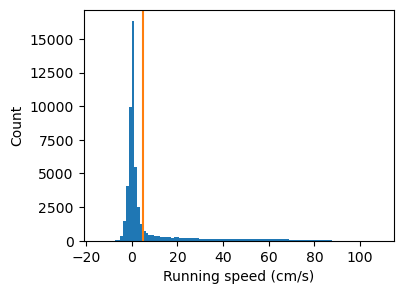

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.hist(stim_table["mean_running_speed"],100)
ax.axvline(5, c='C1')
ax.set_xlabel('Running speed (cm/s)')
ax.set_ylabel('Count');

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.i:</strong> Add a new column to the stimulus table named <code>'running'</code>, with values set to <code>True</code> if the running speed is greater than 5 cm/s, otherwise <code>False</code>.

</div>

In [13]:
stim_table["running"] = stim_table["mean_running_speed"] > 5

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.j:</strong> Try using the <code>make_response_array</code> function using the session's spike times and stimulus table.
<p>
Why does it fail? Modify the stimulus table as needed to ensure the function succeeds. (Alternatively, you could modify the function.)
    
</div>

<details>
    <summary>Click for a <strong>Hint:</strong></summary>
    We want to decode <code>'stimulus_condition_id'</code>. Rename (or duplicate) appropriate columns to <code>'end_time'</code> and <code>'image_name'</code> respectively.
</details>

In [14]:
# make_response_array(session.spike_times, stim_table, good_units[good_units['structure_acronym'] == 'VISp'], window=.1)

In [15]:
stim_table.rename(columns={'stop_time': 'end_time', 'stimulus_condition_id': 'image_name'}, inplace=True)

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.k:</strong> Plot the number of good units (y-axis) for each brain structure (x-axis).  

</div>

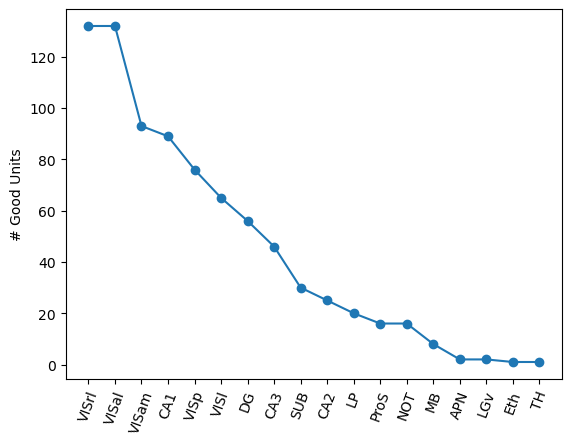

In [16]:
structures = good_units['structure_acronym'].unique()
plt.plot(good_units['structure_acronym'].value_counts(), 'o-')
plt.ylabel("# Good Units")
plt.xticks(range(len(structures)), structures, rotation=70);

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.l:</strong> Create a function <code>decode(area_of_interest, selection, window, n_splits)</code> that returns the accuracies of stimulus decoding in <code>area_of_interest</code> for a given <code>selection</code> of stimulus presentations.
</div>

<details>
    <summary>Click for <strong>Hints:</strong></summary>
    Revisiting the steps performed in the lecture will help to create the function that
    <ol>
    <li>selects from the <code>good_units</code> the ones in the <code>area_of_interest</code> (see Prompt 2.1.e)</li>
    <li>selects the stimulus presentations from our annotated stimulus presentations table according to the <code>selection</code> dictionary (see Prompt 2.1.f+g)</li>
    <li>creates <code>responses</code> and <code>labels</code> using the function <code>make_response_array</code> with window size <code>window</code></li>
    <li>uses <code>sklearn.model_selection.KFold</code> to split the data into "train" and "test" sets for <code>n_splits</code> iterations, and for each iteration trains a <code>sklearn.svm.SVC</code> on the training set and calculates the accuracy on the test set</li>
    <li>returns a list/array of length <code>n_splits</code> with the accuracies for each split</li>
    </ol>
    The signature of the function with default args could be 
    <p>
    <code>def decode(area_of_interest='VISp',
            selection={"stimulus_name": 'natural_scenes', "running": True},
            window=.25,
            num_splits=5):</code>
    </p>
</details>

In [17]:
def decode(area_of_interest='VISp',
           selection={"stimulus_name": 'natural_scenes', "running": True},
           window=.25,
           n_splits=5):

    area_units = good_units[good_units['structure_acronym'] == area_of_interest]

    stimulus_presentations = stim_table.copy()
    for k, v in selection.items():
        stimulus_presentations = stimulus_presentations[stimulus_presentations[k] == v]

    responses, labels = make_response_array(session.spike_times, stimulus_presentations, area_units, window=window)

    np.random.seed(0)
    accuracies = []
    for train_indices, test_indices in KFold(n_splits=n_splits, shuffle=True).split(responses):
        clf = svm.SVC()
        clf.fit(responses[train_indices], labels[train_indices])
        test_targets = labels[test_indices]
        test_predictions = clf.predict(responses[test_indices])
        accuracy = np.mean(test_targets == test_predictions)    
        accuracies.append(accuracy)
            
    return np.array(accuracies)

<div class="alert alert-block alert-success">

<strong>Prompt 2.1.m:</strong> Equipped with this function, 
<p> for each <code>stimulus_name</code> from Prompt 2.1.f, (i.e. 'gabors', 'drifting_gratings', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast'),
<p> &emsp;&emsp; for both <code>"running"</code> and <code>"not_running"</code> trials,
<p> &emsp;&emsp;&emsp;&emsp; calculate and store the decoding accuracy for each recorded brain <code>structure</code>.
</div>

<details>
    <summary>Click to receive a <strong>Hint</strong> for faster processing:</summary>
    You could use <code>multiprocessing.Pool().map()</code> to speed up processing by applying the <code>decode</code> function to all <code>structures</code> in parallel.
</details>

In [18]:
accuracies = {}
for stimulus_name in stimulus_names:
    accuracies[stimulus_name] = {}
    for name, selection in tqdm((("running", {"running": True}),
                                 ("not_running", {"running": False}),
                               )):
        selection["stimulus_name"] = stimulus_name
        my_decode = partial(decode, selection=selection)
        accuracies[stimulus_name][name] = mp.Pool().map(my_decode, structures)

 50%|█████████████████████████████████████████████████████████████                                                             | 1/2 [00:48<00:48, 48.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:18<00:00, 39.17s/it]


<div class="alert alert-block alert-success">

<strong>Prompt 2.1.n:</strong> For each considered <code>stimulus_name</code>, create a figure with an error bar plot of decoding accuracy (y-axis) for each brain area (x-axis) for "running" trials. Add another error bar plot for "not_running" trials using a different color in the same figure, and include a horizontal line indicating chance level performance.

</div>

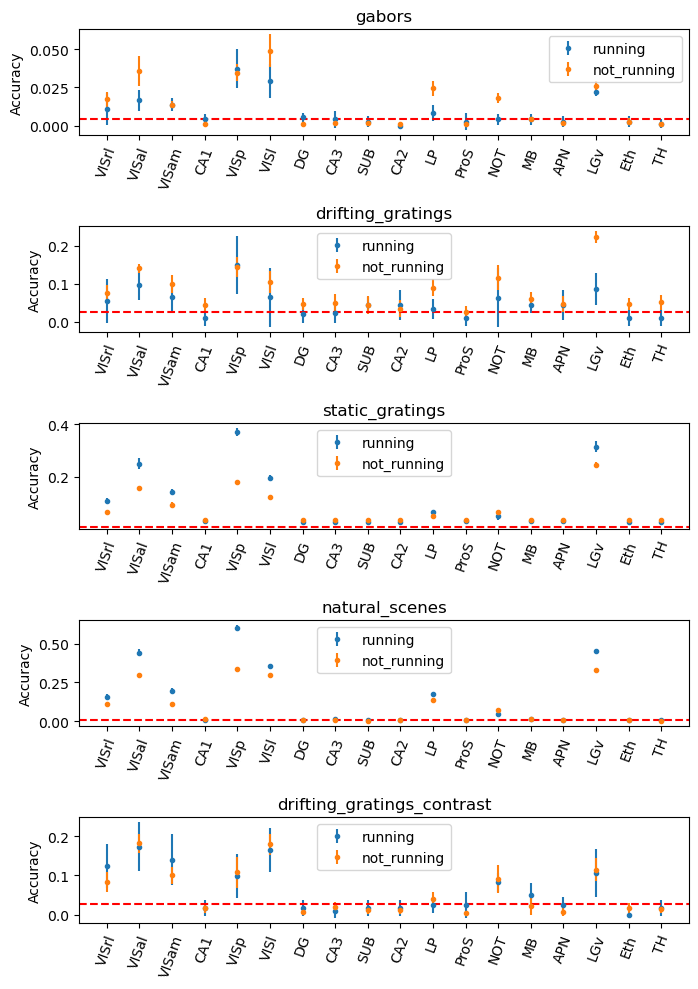

In [19]:
fig,ax = plt.subplots(len(stimulus_names),1,figsize=(7,10))
for i,name in enumerate(stimulus_names):
    for label in ("running", "not_running"):
        ax[i].errorbar(range(len(structures)), np.mean(accuracies[name][label], 1), np.std(accuracies[name][label], 1), 
                     marker='.', ls='none', label=label)
    ax[i].legend()
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xticks(range(len(structures)), structures, rotation=70)
    ax[i].set_title(name)
    num_conditions = len(stim_table[stim_table.stimulus_name == name].image_name.unique())
    ax[i].axhline(1/num_conditions, ls='--', c='r')
fig.tight_layout();

<div class="alert alert-block alert-success">

<h2>Exercise 2.2: Noise Correlations and Modulation by Running</h2>

<p>
In this exercise, we will explore how running modulates neural responses and affects noise correlations. Specifically, we will:
<ol>
<li>Plot total, signal, and noise correlations</li>
<li>Plot the correlations between neural responses and running speed</li>
<li>Compare the noise correlations of all units versus highly modulated units</li>
</ol>

<p>
<strong>Note:</strong> For this exercise, there are comments with detailed prompts that act as guidelines. However, feel free to try completing the task objectives using your own approach first, and consult our prompts if you get stuck.
</p>
    
</div>

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.a:</strong> Make sure you have completed the steps in Prompts 2.1.d-j.

<div class="alert alert-block alert-success">
  
<strong>Prompt 2.2.b:</strong> Consider good units in <code>area_of_interest='VISp'</code> and restrict the stimulus presentations to <code>selection={"stimulus_name": 'drifting_gratings', "running": True}</code>. Using a window size of 250ms, calculate the responses and labels using the <code>make_response_array</code> function.

In [20]:
area_of_interest='VISp'
selection={"stimulus_name": 'drifting_gratings', "running": True}
window=.25

In [ ]:
area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)

stimulus_presentations = stim_table.copy()
for k, v in selection.items():
    stimulus_presentations = stimulus_presentations[stimulus_presentations[k] == v]

responses, labels = make_response_array(
    session.spike_times, stimulus_presentations, area_units, window=window)

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.c:</strong> Calculate and plot total, signal, and mean noise correlations.


In [ ]:
total_correlations = np.corrcoef(responses.T)
stimuli = np.sort(stimulus_presentations['image_name'].unique())
responses_condition = [responses[np.where(labels == stim)] for stim in stimuli]
signal_correlations = np.corrcoef(np.transpose(list(map(lambda x: np.mean(x, 0), responses_condition))))
noise_correlations = list(map(lambda x: np.ma.corrcoef(x.T), responses_condition))
mean_noise_correlations = np.mean(noise_correlations, 0)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
for i, c in enumerate((total_correlations, signal_correlations, mean_noise_correlations)):
    plt.colorbar(ax[i].imshow(c, cmap='bwr', clim=(-1,1)), label='Correlation coefficient')
    ax[i].set_title(f"{('Total', 'Signal', 'Mean Noise')[i]} Correlations")
    ax[i].set_xlabel('Unit #')
    ax[i].set_ylabel('Unit #')
fig.tight_layout()

<div class="alert alert-block alert-success">
    
<strong>Prompt 2.2.d:</strong> For each stimulus condition, calculate the correlation with <code>'mean_running_speed'</code> for each unit. Plot the array (size #conditions x #units) of running speed correlations.

In [ ]:
speed_condition = [np.array(stimulus_presentations["mean_running_speed"])[np.where(labels == stim)]
                   for stim in stimuli]

speed_correlations = np.array([[np.ma.corrcoef(r.T[n], s)[0,1] 
  for n in range(num_units)] for r,s in zip(responses_condition, speed_condition)])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,2))
plt.colorbar(ax.imshow(speed_correlations, cmap='bwr', clim=(-1,1)),
             label='Correlation coefficient')
ax.set_title("Running speed Correlations")
ax.set_xlabel('Unit #')
ax.set_ylabel('Condition');

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.e:</strong> Consider the stimulus condition with the most stimulus presentations. For this condition, plot the <code>'speed_correlations'</code>, showing a threshold of 0.75. Get the indices of the <code>'highly_modulated_units'</code> whose correlation with running speed is greater than 0.75.

In [ ]:
condition = np.argmax([len(s) for s in speed_condition])
# condition = np.argmax([np.sum(s) for s in speed_condition])
fig,ax = plt.subplots(1,2, sharey=True)
ax[0].plot(speed_correlations[condition])
ax[0].set_xlabel('Unit #')
ax[0].set_ylabel('Correlation with running speed')
ax[1].hist(speed_correlations[condition], np.arange(-.95,1,.1), orientation="horizontal")
ax[1].set_xlabel('Count')
for a in ax:
    a.axhline(.75, c='r')
fig.tight_layout()
highly_modulated = np.where(speed_correlations[condition] > .75)[0]
condition, highly_modulated

<div class="alert alert-block alert-success">
    
<strong>Prompt 2.2.f:</strong> Create plots comparing the noise correlations of <code>'highly_modulated_units'</code> to all units.
    
<ol>
<li>Plot the responses (for the considered condition) of those <code>'highly_modulated_units'</code> together with the running speed (use a separate y-axis for the latter).</li>
<li>In another panel, plot the noise correlations (for the considered condition) of the <code>'highly_modulated_units'</code>.</li>
<li>In another panel, plot the histogram of the off-diagonal elements of the noise correlations (for the considered condition) of (1) all units and (2) <code>'highly_modulated_units'</code> (use density, not counts).</li>
</ol>

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,3), width_ratios=(3,2,3))
for i,n in enumerate(highly_modulated):
    ax[0].plot(responses_condition[condition][:,n], label=f"unit {n}")
ax[0].legend(loc=0)
ax[0].set_ylabel('Spike Count')
ax2 = ax[0].twinx()
ax2.plot(speed_condition[condition], 'k--', label='speed')
ax2.legend(loc=2)
ax2.set_xlabel('Stimulus Presentation')
ax2.set_ylabel('Running Speed')

plt.colorbar(ax[1].imshow(noise_correlations[condition][highly_modulated][:,highly_modulated],
                        cmap='bwr', clim=(-1,1)), label='Correlation coefficient')
ax[1].set_title(f"Noise Correlations, condition {stimuli[condition]}")
ax[1].set_xticks(range(len(highly_modulated)), highly_modulated)
ax[1].set_yticks(range(len(highly_modulated)), highly_modulated)
ax[1].set_xlabel('Unit #')
ax[1].set_ylabel('Unit #')

tri = np.triu_indices(len(highly_modulated), k=1)
ax[2].hist(noise_correlations[condition][highly_modulated][:,highly_modulated][tri],
         np.arange(-.95,1,.1), density=True, label="highly correlated units")
tri = np.triu_indices(len(noise_correlations[condition]), k=1)
ax[2].hist(noise_correlations[condition][tri], np.arange(-.95,1,.1), density=True, label="all units")
ax[2].legend()
ax[2].set_title(f"Noise Correlations, condition {stimuli[condition]}")
ax[2].set_xlabel('Correlation coefficient')
ax[2].set_ylabel('Desnity')
fig.tight_layout();

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.g:</strong> Create synthetic data with removed noise correlations by trial-shuffling the neural data (for each condition).

In [ ]:
shuffled_responses_condition = []
for r in responses_condition:
    shuffled_responses_condition.append(r.copy())
    for j in range(num_units):
        np.random.shuffle(shuffled_responses_condition[-1][:,j])
shuffled_responses = np.concatenate(shuffled_responses_condition)
shuffled_responses = shuffled_responses[np.argsort(np.argsort(labels))]

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.h:</strong> Decode the stimuli using a linear SVM on the true and shuffled responses. Repeatedly split into 'train' and 'test' data using <code>StratifiedKFold</code> or <code>LeaveOneOut</code> and calculate the accuracies averaged over splits.
<p> Why not just use KFold as we did in the lecture?
</div>

<details>
    <summary>Click for a <strong>Hint:</strong></summary>
    Consider the number of presentations of each stimulus condition.
</details>

In [ ]:
num_splits = 5
for random_state in (0,1):
    print(f"\nRandom state: {random_state}")
    for Fold in (KFold(n_splits=num_splits, shuffle=True, random_state=random_state),
                 StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=random_state),
                 LeaveOneOut()):
        print(Fold)
        accuracies = []
        shuffled_accuracies = []
        for train_indices, test_indices in Fold.split(responses, labels):
            for r,a in ((responses, accuracies), (shuffled_responses, shuffled_accuracies)):
                clf = svm.SVC()
                clf.fit(r[train_indices], labels[train_indices])
                test_targets = labels[test_indices]
                test_predictions = clf.predict(r[test_indices])
                accuracy = np.mean(test_targets == test_predictions)    
                a.append(accuracy)

        print(f'Mean accuracy:          {np.mean(accuracies)}')
        print(f'Mean accuracy shuffled: {np.mean(shuffled_accuracies)}')

In [ ]:
num_splits = 5
for random_state in (0,1):
    print(f"\nRandom state: {random_state}")
    for Fold in (RepeatedKFold(n_splits=num_splits, random_state=random_state),
                 RepeatedStratifiedKFold(n_splits=num_splits, random_state=random_state),
                 LeaveOneOut()):
        print(Fold)
        accuracies = []
        shuffled_accuracies = []
        for train_indices, test_indices in Fold.split(responses, labels):
            for r,a in ((responses, accuracies), (shuffled_responses, shuffled_accuracies)):
                clf = svm.SVC()
                clf.fit(r[train_indices], labels[train_indices])
                test_targets = labels[test_indices]
                test_predictions = clf.predict(r[test_indices])
                accuracy = np.mean(test_targets == test_predictions)    
                a.append(accuracy)

        print(f'Mean accuracy:          {np.mean(accuracies)}')
        print(f'Mean accuracy shuffled: {np.mean(shuffled_accuracies)}')

In [ ]:
stimulus_presentations.image_name.value_counts()

<div class="alert alert-block alert-success">

<strong>Prompt 2.2.i:</strong> We considered <code>'drifting_gratings'</code>. Change to a static stimulus set and run all cells of this exercise again.